# Makeup
Data Visualization of makeup brands and their products in Python using Jupyter Notebook.

### Introduction

According to [Fortune Business Insights](https://www.fortunebusinessinsights.com/vegan-cosmetics-market-106594), "The global vegan cosmetics market is projected to grow from $15.87 billion in 2021 to $24.79 billion in 2028 at a CAGR of 6.57% in forecast period, 2021-2028..." This statistic got me curious on how the average consumer would change their makeup preferences once companies started to shift more into the 'vegan' category. Using an [API dataset](https://makeup-api.herokuapp.com/api/v1/products.json), I wanted to create an interactive interface where the user would be able to see their favourite brand's vegan products and how they compare with other brands. 


In [1]:
import json #load packages
import pandas as pd 
import numpy as np 
import ipywidgets as widgets
from matplotlib import pyplot as plt 
import matplotlib
import mplcursors
pd.options.mode.chained_assignment = None
pd.set_option("display.max_rows", None)

In [2]:
with open("/Users/jessicanguyen/Desktop/Coding Projects/makeup_api_heroku.json") as f:
    data = json.load(f)

Below are the 2 most important dataframes for this project which is the 'vegan' dataframe and the main 'df' dataframe. Below, I have taken all the elements from the API dataset and inputed them to the 'df' dataframe with column names *Product Type, Product Tags, Brand, Price, Currency, Description, Rating, Product Link*

If I were to do this project again, I would remove the product link and description column. The reason why I inputed these columns was because I wanted to allow the user to go to that specific product's site to purchase, but then ultimately never did.

In [3]:
vegan = pd.DataFrame()
df = pd.DataFrame(columns = ["Product Type","Product Tags","Brand","Price", "Currency", "Description","Rating","Product Link"])
for i in range(0,len(data)):
    currentItem = data[i]
    df.loc[i] = [data[i]["product_type"],data[i]["tag_list"],data[i]["brand"],data[i]["price"], data[i]["currency"],data[i]["description"],data[i]["rating"],data[i]["product_link"]]
    
df.fillna(method='ffill', inplace=True)

But before I'm able to fill in the 'vegan' dataframe, I first have to look at the 'df' dataframe. An issue with the 'df' dataframe is that there are mutliple currencies: USD, CAD, and GBP. We need a uniform currency, so that we can accurately portray the least expensive products to the most expensive products. 

With the code below, I 
1) converted the CAD and GBP to USD in the 'df' dataframe under the category 'Price.' 

2) I then also changed all the 'CAD' and 'GBP' to 'USD' within the 'Currency' column.

In [4]:
for i in range(0,len(data)):
    if data[i]["currency"] == "CAD":
        Converted_Price = (float(data[i]["price"])*1.146)
        df["Price"] = df["Price"].replace([data[i]["price"]],Converted_Price)
        df = df.replace('CAD','USD')
    if data[i]["currency"] == "GBP":
        Converted_Price = (float(data[i]["price"])*1.3603)
        df["Price"] = df["Price"].replace([data[i]["price"]],Converted_Price)
        df = df.replace('GBP','USD')

df = df.replace('USD','USD')

In [5]:
df['Price'] = df['Price'].astype(float) #sort to increasing order
df = df.sort_values(by = ['Price'])

In [6]:
for i in range(0,len(data)): #A product with a price but no currency is assumed to be USD
    if type(data[i]['currency']) == type(None):
        df['Currency'] = df['Currency'].replace([data[i]["currency"]],'USD')

In [7]:
df = df.loc[df['Price'] != 0.00000] #A product that costs $0 is assumed to be irrelevant data

Finally, onto the vegan dataframe.

My task here was to create the 'vegan' dataframe by filling it only with 'vegan' tagged products from the 'df' dataframe. Continuing on, the 'df' dataframe will be useless because we only want to work with vegan products.

1) I first created the 'pt' dictionary that held 'df' index number product: list of product tags. After that, I looked for the word 'vegan' in the values and when I found one, I put the key into a list. As a result, I had the 'v' list that had all the keys of 'vegan' products but I wasn't finished yet. This is because I'm not able to access the 'df' index numbers. 

2) Create a counter that was the length of the main 'df' frame which would act as my index. 

3) Then I took the 'pt' dictionary and 'v' list and compared them. If a selected 'v' value matched for the 'pt' key, then I would get my dummy index number from the counter and add that to the 'lindex' list. The purpose of the 'lindex' list is to have the dummy index list and extract the 'vegan' products that way.


In [8]:
lindex = []
v = []
count = 0
q = 0
j = 0
pt = dict(df['Product Tags'])
pt_k = list(pt.keys())

for i in pt:
    if 'Vegan' in pt[i]:
        v.append(i)

for i in range(len(pt_k)):
    if count > 60:
        break
    elif pt_k[i] == v[count]:
        lindex.append(q)
        count = count + 1
    q = q + 1

for i in lindex:
    veganproduct = df.iloc[i]
    vegan = vegan.append(veganproduct)

,Product Type,Product Tags,Brand,Price,Currency,Description,Rating,Product Link
546,bronzer,[Vegan],e.l.f.,4.9900,USD,\n\t\t\t\t\t\n\t\t\t\t\t\n\t\t\t\t\t\n\t\t\t\t...,4.3,https://well.ca/products/elf-studio-contouring...
577,lip_liner,[Vegan],e.l.f.,4.9900,USD,Achieve longer lasting lip color and sexy plum...,3.7,https://well.ca/products/elf-studio-lip-primer...
648,foundation,[Vegan],e.l.f.,4.9900,USD,Achieve even skin tone \nand naturally radiant...,3.8,https://well.ca/products/elf-studio-tinted-moi...
774,eyeliner,[Vegan],e.l.f.,4.9900,USD,\n\t\t\t\t\t\n\t\t\t\t\t\n\t\t\t\t\t\n\t\t\t\t...,4.3,https://well.ca/products/elf-studio-eye-primer...
779,eyeliner,[Vegan],e.l.f.,4.9900,USD,e.l.f. Studio Cream Eyeliner's creamy formula ...,4.5,https://well.ca/products/elf-studio-cream-eyel...
905,mascara,[Vegan],e.l.f.,4.9900,USD,"Achieve thicker, fuller, and longer lashes tha...",4.8,https://well.ca/products/elf-studio-waterproof...
894,mascara,[Vegan],e.l.f.,4.9900,USD,"Achieve thicker, fuller, and longer lashes tha...",4.0,https://well.ca/products/elf-studio-lengthenin...
875,lipstick,[Vegan],e.l.f.,4.9900,USD,"The velvety, satin texture of e.l.f. Studio Mo...",4.1,https://well.ca/products/elf-studio-moisturizi...
870,lipstick,[Vegan],e.l.f.,4.9900,USD,This convenient jumbo sized lip pencil creates...,4.3,https://well.ca/products/elf-studio-matte-lip-...
909,mascara,[Vegan],e.l.f.,4.9900,USD,e.l.f. Studio Mineral Infused Mascara creates ...,4.3,https://well.ca/products/elf-studio-mineral-in...


The problem with this bar graph is that every single product is listed. That is too many unnecessary data points for our question on **"What is the most affordable vegan makeup brand?"**

The solution here is to find the average prices for each brand. We then will create a bar graph with the x-axis being the brands and the y-axis being the average prices.

<AxesSubplot:xlabel='Brand'>

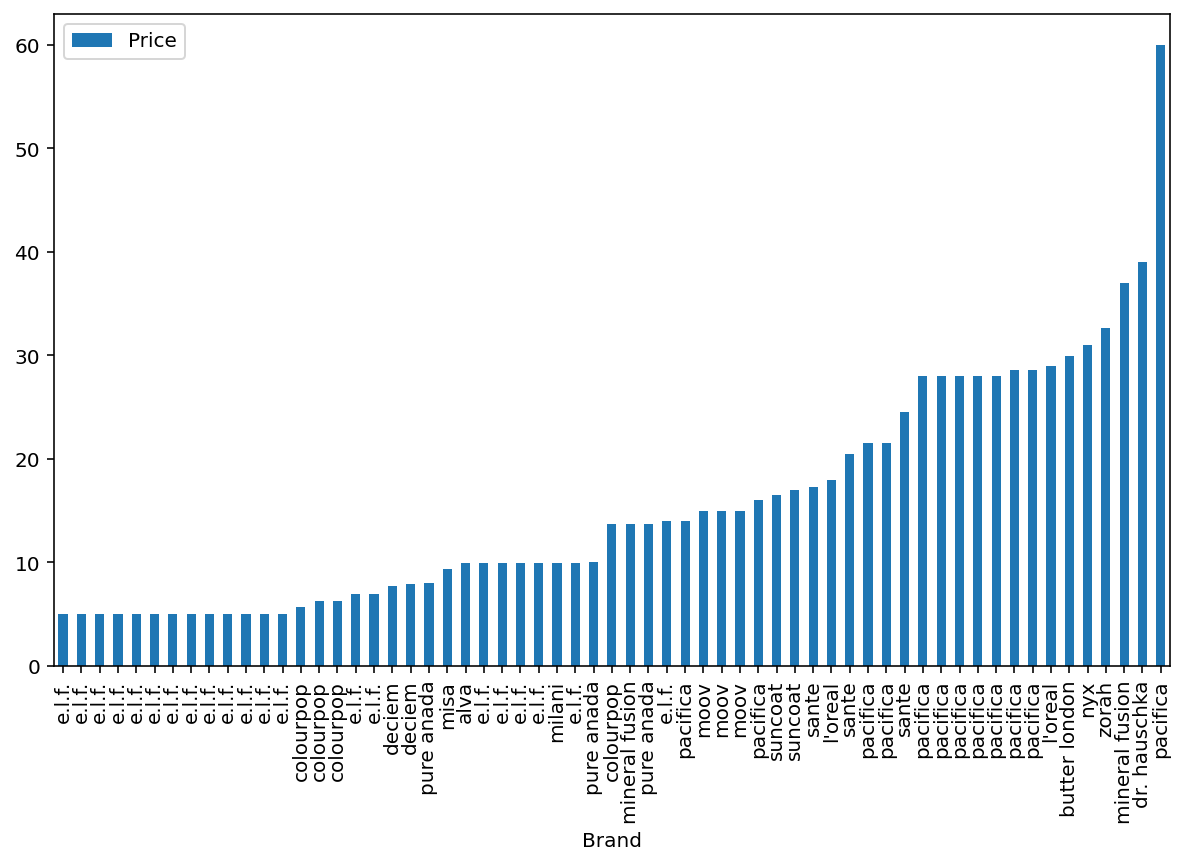

In [9]:
plt.rcParams["figure.figsize"] = [10, 6]
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'
vegan.plot.bar(x='Brand', y='Price')

In [10]:
elf = vegan.loc[vegan['Brand'] == 'e.l.f.'] #creating individual dataframes for each brand
cpop = vegan.loc[vegan['Brand'] == 'colourpop']
deciem = vegan.loc[vegan['Brand'] == 'deciem']
panada = vegan.loc[vegan['Brand'] == 'pure anada']
misa = vegan.loc[vegan['Brand'] == 'misa']
alva = vegan.loc[vegan['Brand'] == 'alva']
milani = vegan.loc[vegan['Brand'] == 'milani']
mineralfusion = vegan.loc[vegan['Brand'] == 'mineral fusion']
pacifica = vegan.loc[vegan['Brand'] == 'pacifica']
moov = vegan.loc[vegan['Brand'] == 'moov']
suncoat = vegan.loc[vegan['Brand'] == 'suncoat']
sante = vegan.loc[vegan['Brand'] == 'sante']
butterlondon = vegan.loc[vegan['Brand'] == 'butter london']
zorah = vegan.loc[vegan['Brand'] == 'zorah']
drhauschka = vegan.loc[vegan['Brand'] == 'dr. hauschka']

Here is my graph that has answered my project's question. As you can see, I made sure to highlight the least expensive brand because that one will be the *most affordable* which is **e.l.f.**. I then shaded the other bars accordingly to darkest being the next relevant brands (next affordable) to the lightest being the least relevant brands (less affordable)

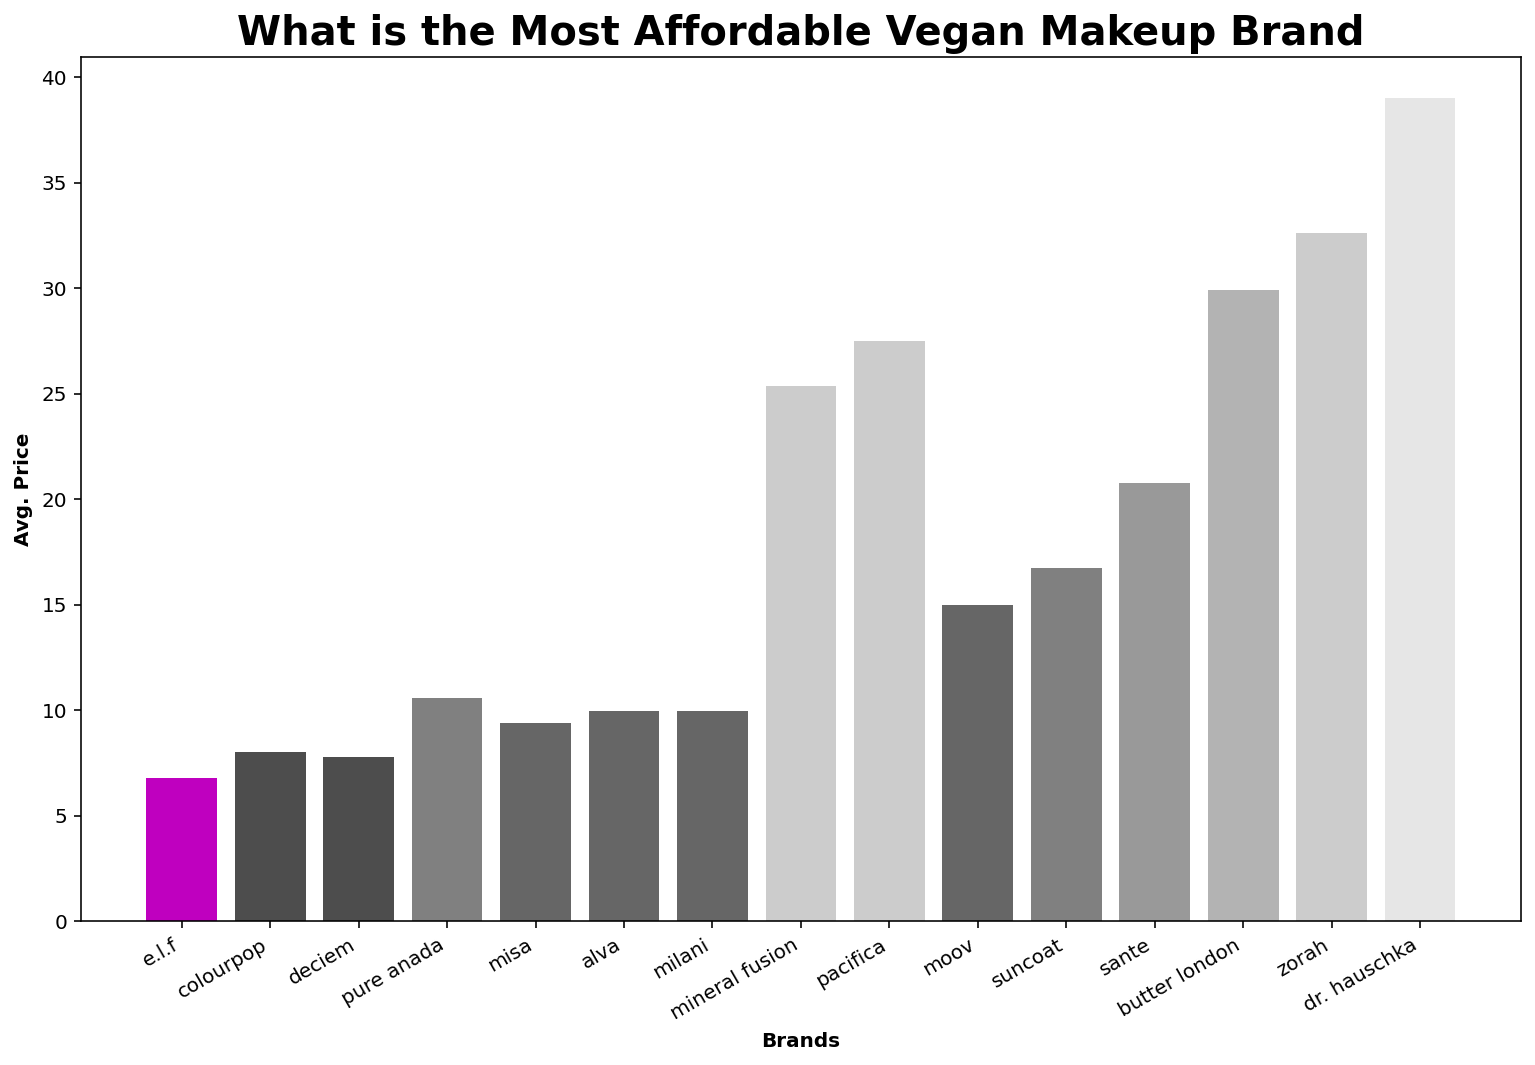

In [11]:
columnbrands = ['e.l.f', 'colourpop', 'deciem', 'pure anada', 'misa','alva','milani','mineral fusion', 'pacifica', 'moov', 'suncoat', 'sante', 'butter london', 'zorah', 'dr. hauschka']
datasets = [elf,cpop,deciem,panada,misa,alva,milani,mineralfusion,pacifica, moov,suncoat,sante,butterlondon,zorah,drhauschka]
yt = []

def avgprice(dataset):
    average = sum(list(dataset['Price'])) / len(list(dataset['Price']))
    return average

for i in range(len(datasets)):
    y_coor = avgprice(datasets[i])
    yt.append(y_coor)

colors = ['m','.3','.3','.5','.4','.4','.4','.8','.8','.4','.5','.6','.7','.8','.9','.9']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(columnbrands,yt, color=colors)
plt.xlabel('Brands',fontweight='bold')
plt.ylabel('Avg. Price',fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.title('What is the Most Affordable Vegan Makeup Brand', fontweight = 'bold', fontsize = 20)
plt.show()

In [21]:
print('The average price for an e.l.f. vegan makeup product is', avgprice(elf))

The average price for an e.l.f. vegan makeup product is 6.7995238095238095


Now, we are entering the zone of widgets and interactive graphs.

There are lists for product types and brand which is useful for the interactive widgets.

In [12]:
Plist = list(df["Product Type"])
Plist = list(set(Plist))

In [13]:
Blist = list(df["Brand"])
Blist = list(set(Blist))

In [14]:
np.random.seed(seed = 20) #color dict for the scatterplots where each color is based on brand
cmap = matplotlib.cm.get_cmap('Spectral')
color_dict = pd.Series({k:cmap(np.random.rand()) for k in vegan['Brand'].unique()})
color_dict.name = 'color_dict'
vegan = pd.merge(vegan,color_dict,how = 'left',left_on = 'Brand',right_index = True)

Here, I have made a function where I take the user's input of product type and create a scatterplot where the x-axis are ratings and y-axis are prices. However, there are still things wrong with the data that I have to mitigate in this function.

* There are NA values for some products' ratings
* There are NA values for some products' prices

The assumptions that I make here are

* An NA value for a product's rating will be replaced with the average rating for those specific vegan products
* An NA value for a product's price will be replaced with the average price for those specific vegan products

For example, if a Maybelline vegan mascara has NA for its *rating*, then it will be replaced with the average rating for mascaras.

In [15]:
def overallproductscatter(producttype): 
    x_points = []
    y_points = []
    use = vegan.loc[vegan['Product Type'] == producttype]
    xname = 'Ratings of ' + producttype
    yname = 'Price of ' + producttype
    titname = 'The Relationship between Ratings and Prices of ' + producttype
    
    lr = list((use['Rating'])) 
    lr_modified = []
    for i in range (len(lr)):
        if lr[i] >= 0: #getting rid of na ratings 
            lr_modified.append(lr[i])
            
    lp = list((use['Price']))
    lp_modified = []
    for i in range (len(lp)):
        if lp[i] >= 0: #getting rid of na prices
            lp_modified.append(lp[i])
    
    if len(lr_modified) == 0: #for eyebrow rating
        lr_modified = lr
        use['Rating'] = use['Rating'].fillna(value= 4)
    else:
        average = sum(lr_modified) / len(lr_modified)
        averageprice = sum(lp_modified) / len(lp_modified)
        use['Rating'] = use['Rating'].fillna(value=average) #filling na values with avg 
        use['Price'] = use['Price'].fillna(value=averageprice)
        
    x_points = list(use['Rating'])
    y_points = list(use['Price'])

    plt.scatter(x_points,y_points, c = use['color_dict'])
    plt.xlabel(xname, fontsize = 15)
    plt.ylabel(yname, fontsize = 15)
    plt.title(titname, fontsize = 20)

Limitations of this scatterplot is that 
1) There is no legend to show what colors each of the brands are
2) There is no pattern to the dots on all of the plots
3) There is no way to know what the dots stand for

I created this to demonstrate that I'm able to create interactive graphs, however, this one is not very useful to look at. 

In [16]:
widgets.interact(overallproductscatter,producttype = Plist)

interactive(children=(Dropdown(description='producttype', options=('lipstick', 'lip_liner', 'nail_polish', 'br…

<function __main__.overallproductscatter(producttype)>

In [17]:
#same code as above
def productscatter(producttype, brand): 
    x_points = []
    y_points = []
    use = vegan.loc[vegan['Product Type'] == producttype]
    xname = 'Ratings of ' + brand 
    yname = 'Price of ' + brand
    titname = 'The Relationship between Ratings and Prices of ' + producttype
    
    lr = list((use['Rating']))
    lr_modified = []
    for i in range (len(lr)):
        if lr[i] >= 0:
            lr_modified.append(lr[i])
            
    lp = list((use['Price']))
    lp_modified = []
    for i in range (len(lp)):
        if lp[i] >= 0:
            lp_modified.append(lp[i])
    
    if len(lr_modified) == 0: #for eyebrow rating
        lr_modified = lr
        use['Rating'] = use['Rating'].fillna(value= 4)
    else:
        average = sum(lr_modified) / len(lr_modified)
        averageprice = sum(lp_modified) / len(lp_modified)
        use['Rating'] = use['Rating'].fillna(value=average)
        use['Price'] = use['Price'].fillna(value=averageprice)
        
    x_points = list(use['Rating'])
    y_points = list(use['Price'])

    useb = use.loc[use['Brand'] == brand]
    useb_ratings = list(useb['Rating'])
    useb_price = list(useb['Price'])
    
    if len(useb_ratings) == 0:
        unavail = "There is no " +producttype + " listed under this brand: " + brand
        plt.scatter(useb_ratings,useb_price, c = useb['color_dict'])
        plt.text(-0.05,0.02,unavail, fontsize = 10, bbox = {'facecolor':'pink', 'alpha':0.3})
    else:
        plt.scatter(useb_ratings,useb_price, c = useb['color_dict'])
    plt.xlabel(xname, fontsize = 15)
    plt.ylabel(yname, fontsize = 15)
    plt.title(titname, fontsize = 20)
    

Here, I created the same graph as above but this one you're able to customize the product you want and the brand that you want.

In [18]:
widgets.interact(productscatter,producttype = Plist, brand = Blist)

interactive(children=(Dropdown(description='producttype', options=('lipstick', 'lip_liner', 'nail_polish', 'br…

<function __main__.productscatter(producttype, brand)>

My conclusion is

**e.l.f. is the most affordable vegan makeup brand with a 6.7995238095238095 average price**

### Further Questions 

To continue further on from this project, I'd like to analyze how user's spending habits will change when it comes to buying vegan makeup or makeup in general (i.e. which products seem to be selling better than others). The purpose of analyzing this would be assist cosmetic companies to see which makeup products they should be investing in and which should be left discontinued or neglected.

### Contact
Jessica N - Jnguye84@gmu.edu
Website - https://jessicanguyen858.wixsite.com/my-site